In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import mlflow
import mlflow.keras
import mlflow.tensorflow

plt.style.use("ggplot")

### Let's talk about how to improve the autoencoder, in detail.
#### If we get an autoencoder with a perfect performance on raw data and also a perfect recall score on the fake dataset
#### We will be the best

In [0]:
working_path = "dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/"

display(dbutils.fs.ls(working_path))

path,name,size
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/Features.csv,Features.csv,107657595
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/NewFeaturesFinal.csv,NewFeaturesFinal.csv,116243380
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/UnseenFeatures14days.csv,UnseenFeatures14days.csv,10914576
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_test_res.csv,X_test_res.csv,20106033
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res-1.csv,X_train_res-1.csv,40679637
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res.csv,X_train_res.csv,59024700
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium.csv,X_tsf_20_medium.csv,217685299
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium_with_index.csv,X_tsf_20_medium_with_index.csv,218615307
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_unseen_20_medium_index.csv,X_tsf_unseen_20_medium_index.csv,2092565
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_window_20.csv,X_tsf_window_20.csv,35669827


In [0]:
# Load vehicle list and nonfailure failure set
vehicles = pd.read_csv('/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/vehicle_list.csv')
dpf_normal = []
dpf_failure = []

for i, e in vehicles.iterrows():
    if(e.dpf_failure == 'No'):
        dpf_normal.append(e.platform_id)
    else:
        dpf_failure.append(e.platform_id)
len(dpf_normal)

Out[5]: 69

In [0]:
## All functions for labeling and generating training/testing set

window_size = 8

def generate_windows(data, ws=window_size, scaler=StandardScaler):
    ll = len(data)
    label = data.label.tolist()
    data_copy = data.copy(deep=True)
    try:
      data_copy = data_copy.drop('window_end',axis=1)
      data_copy = data_copy.drop('label', axis=1)
    except:
      print("Window_end and label column not found in the input data")
      
    dd = scaler().fit_transform(data_copy)
    X = []
    y = []
    label_windowed = []
    
    if ws>ll:
        print(f'window size bigger than data, return null. ll:{ll}, ws:{ws}')
        return None,None,None
      
    for i in range(0, (ll - ws)):
        X.append(dd[i:i+ws])
        y.append(dd[i:i+ws])
        label_windowed.append(label[i:i+ws])
    
    return X, y, label_windowed
  
def generate_s_windows(data, ws=window_size, scaler=StandardScaler):
  if(type(data) != pd.core.frame.DataFrame):
    print("Require 2D dataframe only with dpf_failure data")
    return null
  ll = len(data)
  label = data.label.tolist()
  data_copy = data.copy(deep=True)
  try:
    data_copy = data_copy.drop('platform_id',axis=1)
  except: 
    print('platform_id not found in original dataset. Skip dropping...')
  try:
    data_copy = data_copy.drop('window_end',axis=1)
  except:
    print("Window_end not found in the input data")
  try:
    data_copy = data_copy.drop('label', axis=1)
  except:
    print('label not found in the input data')
  
  dd = scaler().fit_transform(data_copy)
  X = []
  y = []
  label_windowed = []
  
  if ws>ll:
      print('window size bigger than data, return null')
      return None,None,None
      
  for i in range(0, (ll - ws)):
      X.append(dd[i:i+ws])
      y.append(dd[i:i+ws])
      label_windowed.append(1)

  return X, y, label_windowed

# this is just to generate a histogram for the 0s, 1s, and 2s.
def generate_single_labels(data, ws=window_size):
    ll = len(data)
    label = data.label.tolist()
    label_windowed = []
    for i in range(0, (ll - ws)):
        label_windowed.append(label[i:i+ws])
    
    return label_windowed

# same
def generate_labels(data, ws=window_size, failure = dpf_failure):
    labels_windowed = []
    for i in failure: # Add each truck to training data
        labels = generate_single_labels(data.loc[i,:])
        labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    return true_labels

def generate_training(data, ws=window_size, normal = dpf_normal,random=0):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None): # When ws smaller than or equal to the data len
            Xs += X
            Ys += y
    X_tr, X_ts, y_tr, y_ts = [np.array(x) for x in train_test_split(Xs, Ys,random_state=random)]
    return (X_tr, y_tr, X_ts, y_ts)

def generate_all_training(data, ws=window_size, normal = dpf_normal):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            Ys += y
    x1, x2 = [np.array(x) for x in (Xs,Ys)]
    return (x1,x2)
  
def generate_total_training(data,ws=window_size,normal=dpf_normal,failure=dpf_failure):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            Ys += y

    labels_windowed = []
    Xsf = []
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xsf += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xsf,true_labels)
    
    to_remove = []
    for i in range(0,len(true_labels_updated)):
        if true_labels_updated[i]==1:
            to_remove.append(i) #record the positions to remove
    print("To remove: ",len(to_remove))
    for i in sorted(to_remove, reverse = True):
        del X_updated[i]
        
    x_total = Xs + X_updated
    
    y1, y2 = [np.array(x) for x in (x_total,x_total)]
    return (y1,y2)

def generate_s_training(data, ws=window_size):
    Xs = []
    Ys = []
    for i in data.index.levels[0]:
        X,y,labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            Ys += y
    x1, x2 = [np.array(x) for x in (Xs,Ys)]
    return (x1,x2)
  
def generate_testing(data, ws=window_size, failure = dpf_failure, random=0):
    '''
    return: 
        Xtr, Xts - data from the dpf_failure ones
        y_tr, y_ts - labels from the dpf_failure windows
    '''
    Xs = []
    labels_windowed = [] # testing data needs label
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs = Xs + X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    X_tr, X_ts, y_tr, y_ts = [np.array(x) for x in train_test_split(X_updated, true_labels_updated, random_state=random)]
    #@@!! hopefully, this will distribute the correct label to the correct window after train_test_split
    
    print('last platform_id: ',i)
    return (X_tr, y_tr, X_ts, y_ts)

#@@ I don't want to test if X_updated is mapped correctly to the true_labels, but problems maybe here

def generate_all_testing(data, ws=window_size, failure = dpf_failure): # no train test split
    '''
    returns a tuple of testing data, X mapped to its label
    '''
    Xs = []
    labels_windowed = []
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)

def generate_single_testing(data,ws=window_size,failure=dpf_failure,whichfail=0):
    Xs = []
    labels_windowed = []
    fail = failure[whichfail]
    print("Which fail: ",whichfail)
    X, y, labels = generate_windows(data.loc[fail,:],ws)
    if (X!=None):
        Xs += X
        labels_windowed += labels
    else:
        print("window size too big for this platform")
        return (None,None)
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)

def generate_single_testing_normal(data,ws=window_size,normal=dpf_normal,whichnormal=0):
    Xs = []
    labels_windowed = []
    norm = normal[whichnormal]
    print("Which normal: ",whichnormal)
    X, y, labels = generate_windows(data.loc[norm,:],ws)
    if (X!=None):
        Xs += X
        labels_windowed += labels
    else:
        print("window size too big for this platform")
        return (None,None)
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)

def generate_s_testing(data, dataf, ws=window_size):
    Xs = []
    labels_windowed = []
    for i in data.index.levels[0]: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    Xf, yf, labelf = generate_s_windows(dataf,ws)
    
    print(len(Xf))
    print(len(X_updated))
    
    for i in Xf:
        if (i!=None):
            X_updated.append(i)
    for k in labelf:
        if (k!=None):
            true_labels_updated.append(k)
    
    print('y1len:',len(X_updated))
    print('y2len:', len(true_labels_updated))
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)
    
def generate_class(a_data, ws = window_size, failure = dpf_failure):
    ll = 0
    dpf_class = []
    
    for i in failure:
        truck_all = a_data.loc[i,:]
        ll = len(truck_all)
        
        
        for j in range(0, (ll-ws)):
#             print(i,j+ws)
#             print(truck_all['Failure'].iloc[j+ws])
            
            if(truck_all['Failure'].iloc[j+ws]==1):
                dpf_class.append(1)
            else:
                dpf_class.append(0)
    return dpf_class
  
def extract_raw(data):
    frames = []
    for i, e in vehicles.iterrows():
        tmp = data[data['platform_id']==e.platform_id]
        try: 
            del tmp['Unnamed: 0']
        except:
            None
        frames.append(tmp)
        
    data_all = pd.concat(frames, axis=0,  keys=vehicles.platform_id.tolist()) # The order of the vehicle.platform_id is the same as tmp's
    return data_all

def extract_trainingdf(data):
    frames = []
    for i, e in vehicles.iterrows():
        tmp = data[data['platform_id']==e.platform_id]
        try: 
            del tmp['Unnamed: 0']
            del tmp['Unnamed: 1']
        except:
            None
        try: 
            del tmp['platform_id']
        except:
            None
        frames.append(tmp)
        
    data_all = pd.concat(frames, axis=0,  keys=vehicles.platform_id.tolist()) # The order of the vehicle.platform_id is the same as tmp's
    return data_all

def label_window(label):
    ''' This function is to generate correct label for each window in the training data. 
    input: 
        label - the set of labels for all data (2D array)
    
    '''
    true_label = []
    
    for i in range(0,len(label)):
        if label[i].any():
            check_if_all_1s = True
            for q in range(0,len(label[i])):
                if q!=len(label[i])-1 and label[i][q]==1 and label[i][q+1]==0: # case of 0001100
#                     print(f"2: over dpf_failure. Window:{i}, Which:",q)
                    true_label.append(2)
                    check_if_all_1s = False
                    break
            if(check_if_all_1s):
#                 print(f"1: 14 days within dpf_failure. Window:{i}, Which:",q)
#                 print('label:',label[i][q])
                true_label.append(1)
        else: 
            true_label.append(0) # Simply all 0s = non-failure
            
#     for i in range(0,len(label)):
#         if label[i].any():
#             true_label.append(2)
#         else:
#             if i!=len(label)-1:
#                 if label[i+1].any():
#                     true_label.append(1)
#                 else:
#                     true_label.append(0)
#             else:
#                 true_label.append(0)
    print("Number of 1s: ",true_label.count(1))
    print("This number should be close to #1s * 14 in tsf_labeled")
    print("Number of 0s: ",true_label.count(0))
    return true_label

def remove_label2(data,label):
    ''' This function is to remove data labeled 2 from a single dataframe

    Returns
    -------
    updated data and label


    '''
    to_remove = []
    for i in range(0,len(data)):
        if label[i]==2:
            to_remove.append(i) #record the positions to remove
    for i in sorted(to_remove, reverse = True):
        del data[i]
        del label[i]
    return data,label

In [0]:
def mse_sum(mse):
    mse_sum=[]
    for i in range(0,mse.shape[0]):
        mse_sum.append(np.sum(mse[i]))
    len(mse_sum)
    return mse_sum
  
def create_LSTM_test_model(tsf,dropout,window,optimizer='Adam', epochs= 60, lstm1 = 20, lstm2 = 10, learning_rate = 0.01):

#   lstm1 = 20
#   lstm2 = 10
  X, y = generate_total_training(tsf, window)
  train_shape=X

  model2 = tensorflow.keras.Sequential()
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
  model2.add(tensorflow.keras.layers.Dropout(rate=dropout))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
  model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
  model2.add(tensorflow.keras.layers.Dropout(rate=dropout))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
  model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))

  optimizer_call = getattr(tensorflow.keras.optimizers, optimizer)
  optimizer = optimizer_call(learning_rate=learning_rate)

  # Compile model
  model2.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                             mode='auto', baseline=None,restore_best_weights=True)

  history = model2.fit(X, y, validation_split=.2, epochs=epochs, verbose=2, callbacks=[early_stop])
  plt.plot(history.history["loss"], label="Training Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.title("LSTM Autoencoder Training/Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  # MSE loss
  X_pred = model2.predict(X)
  train_mse_loss = np.mean(np.power(X_pred - y,2), axis=1)
  train_mse_loss = train_mse_loss.reshape((-1))

  plt.hist(train_mse_loss, bins=10)
  plt.title("MSE Loss")
  plt.xlabel("Training MSE Loss")
  plt.ylabel("No of samples")
  plt.show()
  A, l = generate_all_testing(tsf,window)
  A_pred = model2.predict(A)
  mse = np.mean(np.power(A - A_pred, 2), axis=1)
  ms = mse_sum(mse)
  error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
  error_df_test = error_df_test.reset_index()
  threshold_fixed = 4
  groups = error_df_test.groupby('True_class')
  fig, ax = plt.subplots()
  for name, group in groups:
      ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
              label= "Failure" if name == 1 else "Normal")

  ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
  ax.legend()
  plt.title("Reconstruction error for different classes")
  plt.ylabel("Reconstruction error")
  plt.xlabel("Data point index")
  plt.show();
  classes = ['Normal','Failure']
  y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
  conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
  plt.title("Confusion matrix")
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  plt.show()
  print('\nClassification Report:')
  print(classification_report(error_df_test.True_class, y_pred))
  print('\nF1 Score:')
  print(f1_score(error_df_test.True_class, y_pred, average = None))

In [0]:
synthetic = pd.read_csv("/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/synthetic_top_50.csv")
synthetic_train = synthetic[synthetic['label']==0]
synthetic_fail = synthetic[synthetic['label']==1]
s_train = extract_trainingdf(synthetic_train)
X, y = generate_s_training(s_train,10)
train_shape = X

In [0]:
tsf_comp = pd.read_csv("/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_window_20_comprehensive_label.csv")
tsf_comp_processed = extract_trainingdf(tsf_comp)
tsf_comp_processed.loc[309450,:].label.tolist().count(1)

Out[8]: 13

In [0]:
X, y = generate_total_training(tsf_comp_processed, 50)

window size bigger than data, return null. ll:28, ws:50
Number of 1s: 1302
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 51348
To remove: 1302

In [0]:
train_data = tsf_comp_processed

In [0]:
# This function needs the shape of the training data.

def create_LSTM_window_tuned(n):
  '''
  param: 
    nfirst - first layer
    nsecond - second layer
    dropout - dropout rate
  '''
#   lstm1 = n['lstm_l1']
#   lstm2 = n['lstm_l2']
  lstm1 = 30
  lstm2 = 15
#   X, y = generate_s_training(train_data,int(n['window_size']))
  train_shape=X

  model2 = tensorflow.keras.Sequential()
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
  model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
  model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))
  return model2

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials

# This function is taking the input of train_shape
def runLSTM_tune_window(n):
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_LSTM_window_tuned(n)
 
  # Select optimizer
  optimizer_call = getattr(tensorflow.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n['learning_rate'])
#   optimizer = optimizer_call(learning_rate=0.01)

  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                             mode='auto', baseline=None,restore_best_weights=True)
  
#   X, y = generate_s_training(train_data,int(n['window_size']))
  
  history = model.fit(X, y, validation_split=.2, epochs=int(n['epochs']), verbose=2, callbacks=[early_stop])
#   history = model.fit(X, y, validation_split=.2, epochs=10, verbose=2, callbacks=[early_stop])

  # Evaluate the model
  score = model.evaluate(X, y, verbose=0)
  return {"loss": score[0], "status": STATUS_OK}

In [0]:
#Hyperopt search space
space50 = {
#   "lstm_l1": hp.quniform("lstm_l1", 10, 25, 1),
#   "lstm_l2": hp.quniform("lstm_l2", 1, 10, 1),
#   "window_size": hp.quniform("window_size", 15, 30, 1),
  "epochs": hp.quniform("epochs", 10,100,1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "dropout": hp.loguniform("dropout", -5, -2),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

In [0]:
wsize = 200
X, y = generate_all_training(train_data,wsize)

window size bigger than data, return null. ll:28, ws:200
window size bigger than data, return null. ll:72, ws:200
window size bigger than data, return null. ll:76, ws:200

In [0]:
spark_trials = SparkTrials()
with mlflow.start_run():
  best_hyperparam50 = fmin(fn=runLSTM_tune_window, 
                         space=space50, 
                         algo=tpe.suggest,
                         max_evals=30, 
                         trials=spark_trials)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (24), which is Spark's default parallelism (24), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?]trial task 23 failed, exception is object of type 'NoneType' has no len().
 Traceback (most recent call last):
 File "/databricks/.python_edge_libs/hyperopt/spark.py", line 540, in run_task_on_executor
 result = domain.evaluate(params, ctrl=None, attach_attachments=False)
 File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
 rval = self.fn(pyll_rval)
 File "<command-85617>", line 25, in runLSTM_tune_window
 File "/databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py", line 1213, in safe_patch_function
 patch_function.call(call_original, *args, **kwargs)
 File "/databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py", line 649, in call
 return cls().__call__(original, *args, **kwargs)
 File "/databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py", line 660, in __call__
 raise e
 File "/databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py", line 653, in __call__
 return self._patch_implementation(original, *args, **kwargs)
 File "/databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py", line 965, in _patch_implementation
 result = super(PatchWithManagedRun, self)._patch_implementation(
 File "/databricks/python/lib/python3.8/site-packages/mlflow/tensorflow.py", line 1088, in _patch_implementation
 history = original(inst, *args, **kwargs)
 File "/databricks/python/lib/python3.8/site-packages/mlflow/utils/autologging_utils/__init__.py", line 1171, in call_original
 original_result = original(*og_args, **og_kwargs)
 File "/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1145, in fit
 callbacks.on_epoch_end(epoch, epoch_logs)
 File "/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/callbacks.py", line 432, in on_epoch_end
 callback.on_epoch_end(epoch, numpy_logs)
 File "/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/callbacks.py", line 1778, in on_epoch_end
 self.model.set_weights(self.best_weights)
 File "/databricks/python/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1852, in set_weights
 if expected_num_weights != len(weights):
TypeError: object of type 'NoneType' has no len()

 3%|▎ | 1/30 [16:53<8:09:42, 1013.18s/trial, best loss: 0.9924389123916626] 7%|▋ | 2/30 [18:16<5:42:37, 734.19s/trial, best loss: 0.8536353707313538]  10%|█ | 3/30 [20:23<4:08:25, 552.07s/trial, best loss: 0.8536353707313538] 13%|█▎ | 4/30 [21:05<2:52:55, 399.07s/trial, best loss: 0.8536353707313538] 17%|█▋ | 5/30 [21:51<2:02:06, 293.05s/trial, best loss: 0.7209458351135254] 20%|██ | 6/30 [25:17<1:46:47, 266.99s/trial, best loss: 0.7209458351135254]trial task 26 failed, exception is object of type 'NoneType' has no len().
 Traceback (most recent call last):
 File "/databricks/.python_edge_libs/hyperopt/spark.py", line 540, in run_task_on_executor
 result = domain.evaluate(params, ctrl=None, attach_attachments=False)
 File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
 rv

In [0]:
import hyperopt
print(hyperopt.space_eval(space50, best_hyperparam50))

{'dropout': 0.007495496816323841, 'epochs': 34.0, 'learning_rate': 0.012589103721635672, 'optimizer': 'Adam'}

window size bigger than data, return null. ll:28, ws:200
window size bigger than data, return null. ll:72, ws:200
window size bigger than data, return null. ll:76, ws:200
Number of 1s: 784
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 28928
To remove: 784
Epoch 1/34
1519/1519 - 723s - loss: 0.6957 - mse: 0.6957 - val_loss: 0.6113 - val_mse: 0.6113
Epoch 2/34
1519/1519 - 702s - loss: 0.5325 - mse: 0.5325 - val_loss: 0.5499 - val_mse: 0.5499
Epoch 3/34
1519/1519 - 707s - loss: 0.4680 - mse: 0.4680 - val_loss: 0.5352 - val_mse: 0.5352
Epoch 4/34
1519/1519 - 710s - loss: 0.4315 - mse: 0.4315 - val_loss: 0.5438 - val_mse: 0.5438
Epoch 5/34
1519/1519 - 709s - loss: 0.4042 - mse: 0.4042 - val_loss: 0.5155 - val_mse: 0.5155
Epoch 6/34
1519/1519 - 702s - loss: 0.3848 - mse: 0.3848 - val_loss: 0.5145 - val_mse: 0.5145
Epoch 7/34
1519/1519 - 697s - loss: 0.3876 - mse: 0.3876 - val_loss: 0.5830 - val_mse: 0.5830
Epoch 8/34
1519/1519 - 699s - loss: 0.4527 - mse: 0.4527 - val_loss: 0.5523 - val_mse: 0.5523
Epoch 9/34
1519/1519 - 699s - loss: 0.4001 - mse: 0.4001 - val_loss: 0.5578 - val_mse: 0.5578
Epoch 10/34
1519/1519 - 706s - loss: 0.3765 - mse: 0.3765 - val_loss: 0.5553 - val_mse: 0.5553

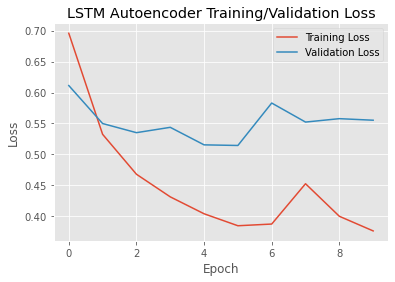

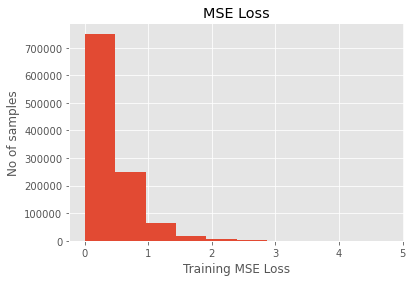

In [0]:
tsf = train_data
dropout = 0.00749549681632384
wsize = 200
window = wsize
optimizer='Adam'
epochs= 34
lstm1 = 100
lstm2 = 50
learning_rate = 0.012589103721635672

X, y = generate_total_training(tsf, window)
train_shape=X

model2 = tensorflow.keras.Sequential()
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
model2.add(tensorflow.keras.layers.Dropout(rate=dropout))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
model2.add(tensorflow.keras.layers.Dropout(rate=dropout))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))

optimizer_call = getattr(tensorflow.keras.optimizers, optimizer)
optimizer = optimizer_call(learning_rate=learning_rate)

# Compile model
model2.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                           mode='auto', baseline=None,restore_best_weights=True)

history = model2.fit(X, y, validation_split=.2, epochs=epochs, verbose=2, callbacks=[early_stop])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Autoencoder Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# MSE loss
X_pred = model2.predict(X)
train_mse_loss = np.mean(np.power(X_pred - y,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=10)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
A, l = generate_single_testing(tsf,window,whichfail=22)
# A, l = generate_single_testing_normal(tsf,window,whichnormal=3)
# A, l = generate_all_testing(tsf,window)
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

Which fail: 22
Number of 1s: 0
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 317

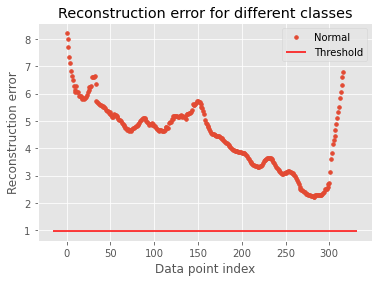

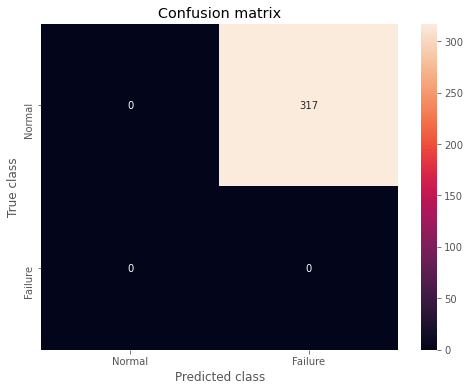

Classification Report:
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
 precision recall f1-score support

 0 0.00 0.00 0.00 317.0
 1 0.00 0.00 0.00 0.0

 accuracy 0.00 317.0
 macro avg 0.00 0.00 0.00 317.0
weighted avg 0.00 0.00 0.00 317.0


F1 Score:
[0. 0.]

In [0]:
threshold_fixed = 0.98
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print('\nClassification Report:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

In [0]:
# A, l = generate_single_testing(tsf,window,whichfail=1)
A, l = generate_single_testing_normal(tsf,window,whichnormal=1)
# A, l = generate_all_testing(tsf,window)
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

Which normal: 1
Number of 1s: 0
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 509

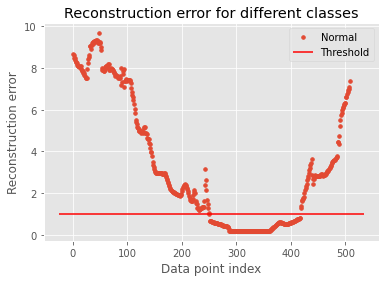

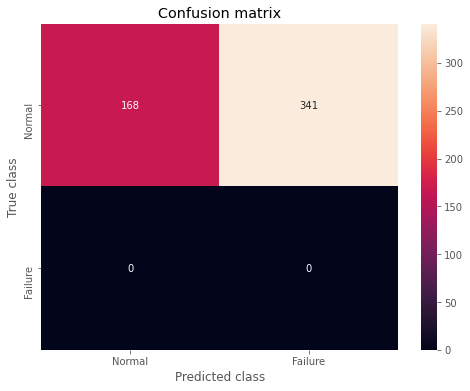

Classification Report:
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
 precision recall f1-score support

 0 1.00 0.33 0.50 509
 1 0.00 0.00 0.00 0

 accuracy 0.33 509
 macro avg 0.50 0.17 0.25 509
weighted avg 1.00 0.33 0.50 509


F1 Score:
[0.49630724 0. ]

In [0]:
threshold_fixed = 0.98
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print('\nClassification Report:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

In [0]:
# A, l = generate_single_testing(tsf,window,whichfail=1)
# A, l = generate_single_testing_normal(tsf,window,whichnormal=3)
A, l = generate_all_testing(tsf,window)
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

Number of 1s: 784
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 28928

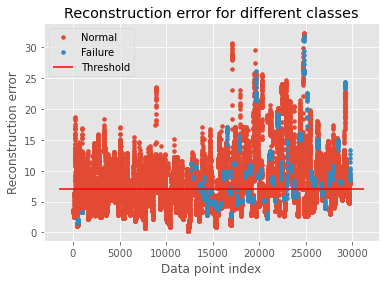

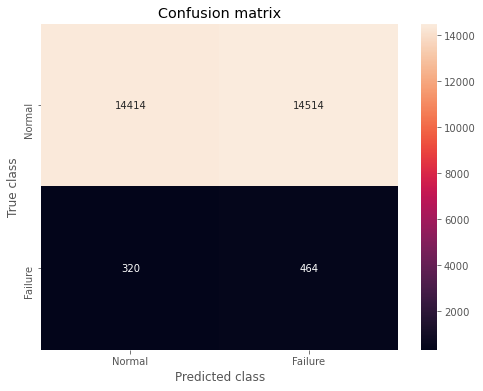

Classification Report:
 precision recall f1-score support

 0 0.98 0.50 0.66 28928
 1 0.03 0.59 0.06 784

 accuracy 0.50 29712
 macro avg 0.50 0.55 0.36 29712
weighted avg 0.95 0.50 0.64 29712


F1 Score:
[0.66025377 0.05887578]

In [0]:
threshold_fixed = 7
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print('\nClassification Report:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

## Back to original dataset

In [0]:
# This function needs the shape of the training data.
def create_LSTM(n):
  '''
  param: 
    nfirst - first layer
    nsecond - second layer
    dropout - dropout rate
  '''
#   lstm1 = n['lstm_l1']
#   lstm2 = n['lstm_l2']
  lstm1 = 15
  lstm2 = 7
#   X, y = generate_total_training(tsf, int(n['window_size']))
  X, y = generate_total_training(tsf, 20)
  train_shape=X

  model2 = tensorflow.keras.Sequential()
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
  model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
  model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))
  return model2

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials

# This function is taking the input of train_shape
def runLSTM(n):
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_LSTM(n)
 
  # Select optimizer
  optimizer_call = getattr(tensorflow.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n['learning_rate'])
#   optimizer = optimizer_call(learning_rate=0.01)

  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                             mode='auto', baseline=None,restore_best_weights=True)
  
#   X, y = generate_total_training(tsf, int(n['window_size']))
  X, y = generate_total_training(tsf, 20)
  
  history = model.fit(X, y, validation_split=.2, epochs=int(n['epochs']), verbose=2, callbacks=[early_stop])
#   history = model.fit(X, y, validation_split=.2, epochs=10, verbose=2, callbacks=[early_stop])

  # Evaluate the model
  score = model.evaluate(X, y, verbose=0)
  return {"loss": score[0], "status": STATUS_OK}

In [0]:
#Hyperopt search space
space = {
#   "lstm_l1": hp.quniform("lstm_l1", 10, 25, 1),
#   "lstm_l2": hp.quniform("lstm_l2", 1, 10, 1),
#   "window_size": hp.quniform("window_size", 15, 30, 1),
  "epochs": hp.quniform("epochs", 10,100,1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "dropout": hp.loguniform("dropout", -5, -2),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

In [0]:
spark_trials = SparkTrials()
with mlflow.start_run():
  best_hyperparam50 = fmin(fn=runLSTM, 
                         space=space, 
                         algo=tpe.suggest,
                         max_evals=30, 
                         trials=spark_trials)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (32), which is Spark's default parallelism (32), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/30 [15:29<7:29:10, 929.32s/trial, best loss: 0.88265061378479] 7%|▋ | 2/30 [16:15<5:10:02, 664.37s/trial, best loss: 0.7781364321708679] 10%|█ | 3/30 [16:23<3:30:22, 467.49s/trial, best loss: 0.7505961656570435] 13%|█▎ | 4/30 [16:31<2:22:50, 329.65s/trial, best loss: 0.7505961656570435] 17%|█▋ | 5/30 [17:20<1:42:16, 245.47s/trial, best loss: 0.7505961656570435] 20%|██ | 6/30 [18:01<1:13:40, 184.17s/trial, best loss: 0.5348532199859619] 23%|██▎ | 7/30 [18:28<52:31, 137.02s/trial, best loss: 0.5348532199859619]  27%|██▋ | 8/30 [18:31<35:30, 96.82s/trial, best loss: 0.5348532199859619]  30%|███ | 9/30 [19:47<31:42, 90.59s/trial, best loss: 0.5348532199859619] 33%|███▎ | 10/30 [20:41<26:27, 79.37s/trial, best loss: 0.528405487537384] 37%|███▋ | 11/30 [21:37<22:55, 72.41s/trial, best loss: 0.5271560549736023] 40%|████ | 12/30 [23:04<23:02, 76.81s/trial, best loss: 0.5271560549736023] 43%|████▎ | 13/30 [26:14<31:23, 110.82s/trial, best loss: 0.5271560549736023] 47%|████▋ | 14/30 [26:17<20:56, 78.51s/trial, best loss: 0.5244132280349731]  50%|█████ | 15/30 [26:51<16:17, 65.16s/trial, best loss: 0.5244132280349731] 53%|█████▎ | 16/30 [32:35<34:44, 148.92s/trial, best loss: 0.5244132280349731] 57%|█████▋ | 17/30 [34:19<29:17, 135.17s/trial, best loss: 0.5244132280349731] 60%|██████ | 18/30 [35:53<24:34, 122.85s/trial, best loss: 0.5244132280349731] 63%|██████▎ | 19/30 [36:13<16:52, 92.00s/trial, best loss: 0.5244132280349731]  67%|██████▋ | 20/30 [36:55<12:50, 77.01s/trial, best loss: 0.5244132280349731] 70%|███████ | 21/30 [37:30<09:39, 64.42s/trial, best loss: 0.5244132280349731] 73%|███████▎ | 22/30 [54:45<47:24, 355.59s/trial, best loss: 0.5244132280349731] 77%|███████▋ | 23/30 [1:02:07<44:31, 381.64s/trial, best loss: 0.5244132280349731] 80%|████████ | 24/30 [1:03:34<29:19, 293.28s/trial, best loss: 0.5244132280349731] 83%|████████▎ | 25/30 [1:04:19<18:14, 218.81s/trial, best loss: 0.5244132280349731] 87%|████████▋ | 26/30 [1:08:38<15:22, 230.64s/trial, best loss: 0.5244132280349731] 90%|█████████ | 27/30 [1:09:26<08:47, 175.87s/trial, best loss: 0.5244132280349731] 93%|█████████▎| 28/30 [1:09:38<04:13, 126.71s/trial, best loss: 0.5244132280349731] 97%|█████████▋| 29/30 [1:16:35<03:33, 213.92s/trial, best loss: 0.5244132280349731]100%|██████████| 30/30 [1:16:37<00:00, 150.35s/trial, best loss: 0.5244132280349731]100%|██████████| 30/30 [1:16:37<00:00, 153.25s/trial, best loss: 0.5244132280349731]
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.

In [0]:
import hyperopt
print(hyperopt.space_eval(space, best_hyperparam50))

{'dropout': 0.017465128311339874, 'epochs': 52.0, 'learning_rate': 0.01071841254384225, 'optimizer': 'Adam'}

In [0]:

lstm1 = 20
lstm2 = 10
X, y = generate_total_training(tsf, 30)
train_shape=X

model2 = tensorflow.keras.Sequential()
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
model2.add(tensorflow.keras.layers.Dropout(rate=0.017465128311339874))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
model2.add(tensorflow.keras.layers.Dropout(rate=0.0071663786111759754))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))

optimizer_call = getattr(tensorflow.keras.optimizers, 'Adam')
optimizer = optimizer_call(learning_rate=0.01071841254384225)

# Compile model
model2.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                           mode='auto', baseline=None,restore_best_weights=True)

history = model2.fit(X, y, validation_split=.2, epochs=52, verbose=2, callbacks=[early_stop])

Number of 1s: 86
This number should be very close to the number of 1s in tsf_labeled
To remove: 86
Epoch 1/52
2448/2448 - 148s - loss: 0.6067 - mse: 0.6067 - val_loss: 0.5634 - val_mse: 0.5634
Epoch 2/52
2448/2448 - 134s - loss: 0.5334 - mse: 0.5334 - val_loss: 0.5403 - val_mse: 0.5403
Epoch 3/52
2448/2448 - 130s - loss: 0.5176 - mse: 0.5176 - val_loss: 0.5246 - val_mse: 0.5246
Epoch 4/52
2448/2448 - 132s - loss: 0.5117 - mse: 0.5117 - val_loss: 0.5298 - val_mse: 0.5298
Epoch 5/52
2448/2448 - 133s - loss: 0.5078 - mse: 0.5078 - val_loss: 0.5243 - val_mse: 0.5243
Epoch 6/52
2448/2448 - 133s - loss: 0.5057 - mse: 0.5057 - val_loss: 0.5180 - val_mse: 0.5180
Epoch 7/52
2448/2448 - 132s - loss: 0.5030 - mse: 0.5030 - val_loss: 0.5201 - val_mse: 0.5201
Epoch 8/52
2448/2448 - 131s - loss: 0.5022 - mse: 0.5022 - val_loss: 0.5163 - val_mse: 0.5163

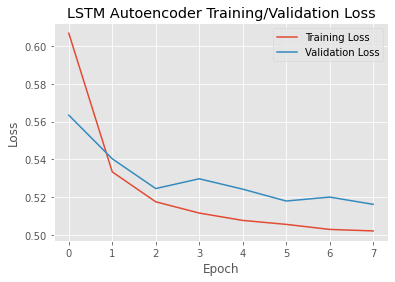

In [0]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Autoencoder Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

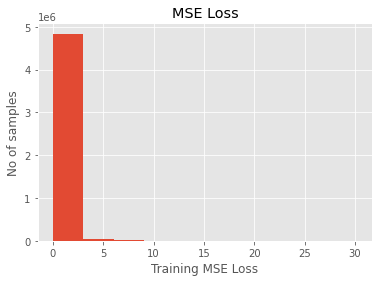

In [0]:
# MSE loss
X_pred = model2.predict(X)
train_mse_loss = np.mean(np.power(X_pred - y,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=10)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
def mse_sum(mse):
    mse_sum=[]
    for i in range(0,mse.shape[0]):
        mse_sum.append(np.sum(mse[i]))
    len(mse_sum)
    return mse_sum

In [0]:
A,l = generate_all_testing(tsf,30)

Number of 1s: 86
This number should be very close to the number of 1s in tsf_labeled

In [0]:
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

In [0]:
threshold_fixed = 15
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-85611> in <module> 
 1 threshold_fixed = 15 
 ----> 2 groups = error_df_test . groupby ( 'True_class' ) 
 3 fig , ax = plt . subplots ( ) 
 4 for name , group in groups : 
 5 ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',

 NameError : name 'error_df_test' is not defined

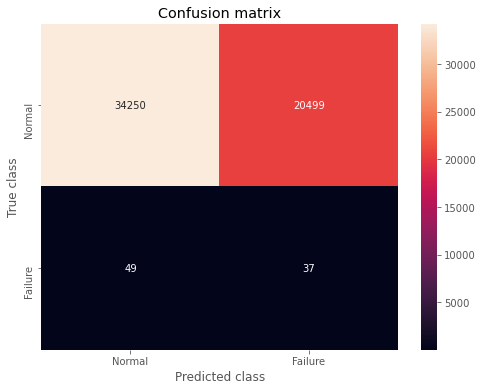

In [0]:
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
print('\nClassification Report:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

Classification Report:
 precision recall f1-score support

 0 1.00 0.65 0.79 57389
 1 0.00 0.42 0.00 86

 accuracy 0.65 57475
 macro avg 0.50 0.53 0.40 57475
weighted avg 1.00 0.65 0.79 57475


F1 Score:
[0.78655554 0.00355047]

## Try with our old dataset

In [0]:
working_path = "dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/"
display(dbutils.fs.ls(working_path))

path,name,size
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/Features.csv,Features.csv,107657595
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/NewFeaturesFinal.csv,NewFeaturesFinal.csv,116243380
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_test_res.csv,X_test_res.csv,20106033
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res-1.csv,X_train_res-1.csv,40679637
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res.csv,X_train_res.csv,59024700
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium.csv,X_tsf_20_medium.csv,217685299
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium_with_index.csv,X_tsf_20_medium_with_index.csv,218615307
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_window_20.csv,X_tsf_window_20.csv,35669827
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/df_rolled.csv,df_rolled.csv,134938298
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/individual_files/,individual_files/,0


In [0]:
tsf_top50 = pd.read_csv("/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/top_50_tsf_medium_w20s1.csv")
tsf_top50.head()

Out[4]:

,platform_id,window_end,F1__has_duplicate_max,F1__last_location_of_maximum,F1__median,F1__longest_strike_above_mean,F1__root_mean_square,F1__kurtosis,F1__mean,F1__first_location_of_minimum,F1__sum_values,F1__last_location_of_minimum,F2__mean_change,F1__percentage_of_reoccurring_values_to_all_values,F1__percentage_of_reoccurring_datapoints_to_all_datapoints,F2__number_cwt_peaks__n_1,"F2__agg_autocorrelation__f_agg_""mean""__maxlag_40",F2__time_reversal_asymmetry_statistic__lag_1,F1__abs_energy,F2__minimum,F1__time_reversal_asymmetry_statistic__lag_1,F1__c3__lag_1,F1__c3__lag_2,F1__c3__lag_3,"F1__agg_autocorrelation__f_agg_""mean""__maxlag_40","F1__agg_autocorrelation__f_agg_""median""__maxlag_40",F1__ratio_value_number_to_time_series_length,F2__benford_correlation,F1__binned_entropy__max_bins_10,F1__value_count__value_0,"F1__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",F1__count_below__t_0,F2__variation_coefficient,F2__first_location_of_maximum,F1__number_cwt_peaks__n_1,F2__c3__lag_3,F2__c3__lag_2,F1__mean_change,F2__c3__lag_1,F2__binned_entropy__max_bins_10,"F2__fft_aggregated__aggtype_""centroid""","F2__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",F1__spkt_welch_density__coeff_5,F1__count_above_mean,F2__has_duplicate_min,F1__time_reversal_asymmetry_statistic__lag_3,F1__time_reversal_asymmetry_statistic__lag_2,F1__maximum,F2__number_cwt_peaks__n_5,F2__longest_strike_below_mean,F2__number_crossing_m__m_0,F1__mean_second_derivative_central,label
0,309450,24,0.0,0.809524,0.901339,6.0,0.875185,2.112501,0.870118,0.047619,18.272488,0.761905,0.000296,0.052632,0.142857,4.0,-0.077136,-1.848733e-06,16.084911,0.004693,0.021482,0.656368,0.658352,0.652279,-0.052675,-0.075841,0.904762,0.848688,1.517464,0.0,8.0,0.0,0.612558,0.047619,5.0,0.000019,0.000023,0.002421,0.000023,2.070493,2.757826,3.0,0.009941,16.0,0.0,0.004215,0.021850,0.967459,4.0,5.0,0.0,0.006907,0
1,309450,25,0.0,0.761905,0.901339,6.0,0.873560,1.943248,0.868475,0.000000,18.237972,0.714286,-0.002396,0.052632,0.142857,3.0,-0.207405,-1.186008e-06,16.025261,0.004693,0.012904,0.664980,0.654390,0.635753,-0.040212,-0.117552,0.904762,0.812764,1.580182,0.0,8.0,0.0,0.638783,0.000000,4.0,0.000017,0.000022,0.009820,0.000023,2.058461,2.859783,7.0,0.011292,15.0,0.0,0.017858,0.010111,0.967459,4.0,6.0,0.0,-0.010019,0
2,309450,26,0.0,0.714286,0.901339,6.0,0.873560,1.943248,0.868475,0.285714,18.237972,1.000000,0.002515,0.052632,0.142857,3.0,-0.071898,-4.821149e-08,16.025261,0.004693,-0.028113,0.661993,0.654143,0.637398,-0.154261,-0.094184,0.904762,0.812764,1.580182,0.0,8.0,0.0,0.638783,0.285714,4.0,0.000012,0.000018,-0.014890,0.000023,2.058461,2.859783,6.0,0.012219,15.0,0.0,-0.036637,-0.034536,0.967459,4.0,6.0,0.0,-0.004487,0
3,309450,27,0.0,0.666667,0.901339,5.0,0.872931,1.982601,0.867891,0.238095,18.225717,0.952381,-0.001244,0.052632,0.142857,3.0,-0.071806,-3.112398e-06,16.002169,0.007077,-0.020452,0.646602,0.648694,0.653331,-0.038835,-0.139628,0.904762,0.847008,1.580182,0.0,8.0,0.0,0.594665,0.238095,5.0,0.000012,0.000017,0.000682,0.000023,2.086674,2.490740,6.0,0.012501,15.0,0.0,-0.006346,-0.028065,0.967459,4.0,6.0,0.0,0.007475,0
4,309450,28,0.0,0.619048,0.899573,5.0,0.871082,1.979470,0.866107,0.190476,18.188244,0.904762,-0.001348,0.052632,0.142857,4.0,-0.098611,-4.315931e-06,15.934447,0.007077,-0.002490,0.633707,0.635282,0.647660,-0.025614,-0.128843,0.904762,0.881329,1.594982,0.0,8.0,0.0,0.612657,0.190476,4.0,0.000009,0.000015,-0.001948,0.000020,2.020660,2.565731,8.0,0.012252,15.0,0.0,-0.006081,-0.028936,0.967459,4.0,6.0,0.0,-0.001238,0


In [0]:
tsf = extract_trainingdf(tsf_top50)
tsf.head()

Out[10]:

window_end 
 F1__has_duplicate_max 
 F1__last_location_of_maximum 
 F1__median 
 F1__longest_strike_above_mean 
 F1__root_mean_square 
 F1__kurtosis 
 F1__mean 
 F1__first_location_of_minimum 
 F1__sum_values 
 F1__last_location_of_minimum 
 F2__mean_change 
 F1__percentage_of_reoccurring_values_to_all_values 
 F1__percentage_of_reoccurring_datapoints_to_all_datapoints 
 F2__number_cwt_peaks__n_1 
 F2__agg_autocorrelation__f_agg_"mean"__maxlag_40 
 F2__time_reversal_asymmetry_statistic__lag_1 
 F1__abs_energy 
 F2__minimum 
 F1__time_reversal_asymmetry_statistic__lag_1 
 F1__c3__lag_1 
 F1__c3__lag_2 
 F1__c3__lag_3 
 F1__agg_autocorrelation__f_agg_"mean"__maxlag_40 
 F1__agg_autocorrelation__f_agg_"median"__maxlag_40 
 F1__ratio_value_number_to_time_series_length 
 F2__benford_correlation 
 F1__binned_entropy__max_bins_10 
 F1__value_count__value_0 
 F1__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC" 
 F1__count_below__t_0 
 F2__variation_coefficient 
 F2__first_location_of_maximum 
 F1__number_cwt_peaks__n_1 
 F2__c3__lag_3 
 F2__c3__lag_2 
 F1__mean_change 
 F2__c3__lag_1 
 F2__binned_entropy__max_bins_10 
 F2__fft_aggregated__aggtype_"centroid" 
 F2__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC" 
 F1__spkt_welch_density__coeff_5 
 F1__count_above_mean 
 F2__has_duplicate_min 
 F1__time_reversal_asymmetry_statistic__lag_3 
 F1__time_reversal_asymmetry_statistic__lag_2 
 F1__maximum 
 F2__number_cwt_peaks__n_5 
 F2__longest_strike_below_mean 
 F2__number_crossing_m__m_0 
 F1__mean_second_derivative_central 
 label 
 
 
 
 
 309450 
 0 
 24 
 0.0 
 0.809524 
 0.901339 
 6.0 
 0.875185 
 2.112501 
 0.870118 
 0.047619 
 18.272488 
 0.761905 
 0.000296 
 0.052632 
 0.142857 
 4.0 
 -0.077136 
 -1.848733e-06 
 16.084911 
 0.004693 
 0.021482 
 0.656368 
 0.658352 
 0.652279 
 -0.052675 
 -0.075841 
 0.904762 
 0.848688 
 1.517464 
 0.0 
 8.0 
 0.0 
 0.612558 
 0.047619 
 5.0 
 0.000019 
 0.000023 
 0.002421 
 0.000023 
 2.070493 
 2.757826 
 3.0 
 0.009941 
 16.0 
 0.0 
 0.004215 
 0.021850 
 0.967459 
 4.0 
 5.0 
 0.0 
 0.006907 
 0 
 
 
 1 
 25 
 0.0 
 0.761905 
 0.901339 
 6.0 
 0.873560 
 1.943248 
 0.868475 
 0.000000 
 18.237972 
 0.714286 
 -0.002396 
 0.052632 
 0.142857 
 3.0 
 -0.207405 
 -1.186008e-06 
 16.025261 
 0.004693 
 0.012904 
 0.664980 
 0.654390 
 0.635753 
 -0.040212 
 -0.117552 
 0.904762 
 0.812764 
 1.580182 
 0.0 
 8.0 
 0.0 
 0.638783 
 0.000000 
 4.0 
 0.000017 
 0.000022 
 0.009820 
 0.000023 
 2.058461 
 2.859783 
 7.0 
 0.011292 
 15.0 
 0.0 
 0.017858 
 0.010111 
 0.967459 
 4.0 
 6.0 
 0.0 
 -0.010019 
 0 
 
 
 2 
 26 
 0.0 
 0.714286 
 0.901339 
 6.0 
 0.873560 
 1.943248 
 0.868475 
 0.285714 
 18.237972 
 1.000000 
 0.002515 
 0.052632 
 0.142857 
 3.0 
 -0.071898 
 -4.821149e-08 
 16.025261 
 0.004693 
 -0.028113 
 0.661993 
 0.654143 
 0.637398 
 -0.154261 
 -0.094184 
 0.904762 
 0.812764 
 1.580182 
 0.0 
 8.0 
 0.0 
 0.638783 
 0.285714 
 4.0 
 0.000012 
 0.000018 
 -0.014890 
 0.000023 
 2.058461 
 2.859783 
 6.0 
 0.012219 
 15.0 
 0.0 
 -0.036637 
 -0.034536 
 0.967459 
 4.0 
 6.0 
 0.0 
 -0.004487 
 0 
 
 
 3 
 27 
 0.0 
 0.666667 
 0.901339 
 5.0 
 0.872931 
 1.982601 
 0.867891 
 0.238095 
 18.225717 
 0.952381 
 -0.001244 
 0.052632 
 0.142857 
 3.0 
 -0.071806 
 -3.112398e-06 
 16.002169 
 0.007077 
 -0.020452 
 0.646602 
 0.648694 
 0.653331 
 -0.038835 
 -0.139628 
 0.904762 
 0.847008 
 1.580182 
 0.0 
 8.0 
 0.0 
 0.594665 
 0.238095 
 5.0 
 0.000012 
 0.000017 
 0.000682 
 0.000023 
 2.086674 
 2.490740 
 6.0 
 0.012501 
 15.0 
 0.0 
 -0.006346 
 -0.028065 
 0.967459 
 4.0 
 6.0 
 0.0 
 0.007475 
 0 
 
 
 4 
 28 
 0.0 
 0.619048 
 0.899573 
 5.0 
 0.871082 
 1.979470 
 0.866107 
 0.190476 
 18.188244 
 0.904762 
 -0.001348 
 0.052632 
 0.142857 
 4.0 
 -0.098611 
 -4.315931e-06 
 15.934447 
 0.007077 
 -0.002490 
 0.633707 
 0.635282 
 0.647660 
 -0.025614 
 -0.128843 
 0.904762 
 0.881329 
 1.594982 
 0.0 
 8.0 
 0.0 
 0.612657 
 0.190476 
 4.0 
 0.000009 


In [0]:
X, y, XX, yy = generate_training(tsf)
X.shape

Out[11]: (33492, 8, 50)

In [0]:
# This function needs the shape of the training data.
def create_LSTM_window_tuned(n):
  '''
  param: 
    nfirst - first layer
    nsecond - second layer
    dropout - dropout rate
  '''
#   lstm1 = n['lstm_l1']
#   lstm2 = n['lstm_l2']
  lstm1 = 12
  lstm2 = 6
  
  X, y, XX, yy = generate_training(tsf,int(n['window_size']))
  train_shape=X

  model2 = tensorflow.keras.Sequential()
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
  model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
  model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))
  return model2

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials

# This function is taking the input of train_shape
def runLSTM_tune_window(n):
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_LSTM_window_tuned(n)
 
  # Select optimizer
  optimizer_call = getattr(tensorflow.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n['learning_rate'])
#   optimizer = optimizer_call(learning_rate=0.01)

  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                             mode='auto', baseline=None,restore_best_weights=True)
  
  X, y, XX, yy = generate_training(tsf,int(n['window_size']))
  
  history = model.fit(X, y, validation_split=.2, epochs=int(n['epochs']), verbose=2, callbacks=[early_stop])
#   history = model.fit(X, y, validation_split=.2, epochs=10, verbose=2, callbacks=[early_stop])

  # Evaluate the model
  score = model.evaluate(XX, yy, verbose=0)
  return {"loss": score[0], "status": STATUS_OK}

In [0]:
#Hyperopt search space
space50 = {
#   "lstm_l1": hp.quniform("lstm_l1", 10, 25, 1),
#   "lstm_l2": hp.quniform("lstm_l2", 1, 10, 1),
  "window_size": hp.quniform("window_size", 12, 30, 1),
  "epochs": hp.quniform("epochs", 10,100,1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "dropout": hp.loguniform("dropout", -5, -2),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

In [0]:
spark_trials = SparkTrials()
with mlflow.start_run():
  best_hyperparam50 = fmin(fn=runLSTM_tune_window, 
                         space=space50, 
                         algo=tpe.suggest,
                         max_evals=30, 
                         trials=spark_trials)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/30 [04:57<2:23:45, 297.43s/trial, best loss: 0.7445939779281616] 7%|▋ | 2/30 [07:01<1:54:32, 245.44s/trial, best loss: 0.7445939779281616] 10%|█ | 3/30 [09:00<1:33:23, 207.54s/trial, best loss: 0.7445939779281616] 13%|█▎ | 4/30 [09:02<1:03:12, 145.88s/trial, best loss: 0.7445939779281616] 17%|█▋ | 5/30 [10:33<53:56, 129.45s/trial, best loss: 0.7445939779281616]  20%|██ | 6/30 [10:38<36:51, 92.16s/trial, best loss: 0.5748695135116577]  23%|██▎ | 7/30 [16:43<1:06:37, 173.82s/trial, best loss: 0.5748695135116577] 27%|██▋ | 8/30 [22:51<1:25:08, 232.19s/trial, best loss: 0.5748695135116577] 30%|███ | 9/30 [26:05<1:17:17, 220.83s/trial, best loss: 0.5708354711532593] 33%|███▎ | 10/30 [28:27<1:05:38, 196.92s/trial, best loss: 0.5708354711532593] 37%|███▋ | 11/30 [29:37<50:18, 158.87s/trial, best loss: 0.5708354711532593]  40%|████ | 12/30 [30:55<40:23, 134.63s/trial, best loss: 0.5708354711532593] 43%|████▎ | 13/30 [31:21<28:54, 102.06s/trial, best loss: 0.5708354711532593] 47%|████▋ | 14/30 [32:51<26:15, 98.47s/trial, best loss: 0.5708354711532593]  50%|█████ | 15/30 [35:14<27:58, 111.88s/trial, best loss: 0.5708354711532593] 53%|█████▎ | 16/30 [37:37<28:17, 121.26s/trial, best loss: 0.5708354711532593] 57%|█████▋ | 17/30 [38:32<21:58, 101.44s/trial, best loss: 0.5566696524620056] 60%|██████ | 18/30 [41:11<23:41, 118.46s/trial, best loss: 0.5566696524620056] 63%|██████▎ | 19/30 [44:07<24:53, 135.78s/trial, best loss: 0.5566696524620056] 67%|██████▋ | 20/30 [44:22<16:35, 99.56s/trial, best loss: 0.5566696524620056]  70%|███████ | 21/30 [47:16<18:17, 121.98s/trial, best loss: 0.535656750202179] 73%|███████▎ | 22/30 [50:56<20:11, 151.46s/trial, best loss: 0.535656750202179] 77%|███████▋ | 23/30 [51:56<14:28, 124.05s/trial, best loss: 0.535656750202179] 80%|████████ | 24/30 [52:20<09:22, 93.74s/trial, best loss: 0.535656750202179]  83%|████████▎ | 25/30 [56:54<12:19, 147.90s/trial, best loss: 0.535656750202179] 87%|████████▋ | 26/30 [57:02<07:03, 105.93s/trial, best loss: 0.535656750202179] 90%|█████████ | 27/30 [59:31<05:56, 118.90s/trial, best loss: 0.535656750202179] 93%|█████████▎| 28/30 [1:02:26<04:31, 135.78s/trial, best loss: 0.535656750202179] 97%|█████████▋| 29/30 [1:02:34<01:37, 97.45s/trial, best loss: 0.535656750202179] 100%|██████████| 30/30 [1:03:19<00:00, 81.73s/trial, best loss: 0.535656750202179]100%|██████████| 30/30 [1:03:19<00:00, 126.66s/trial, best loss: 0.535656750202179]
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.

In [0]:
import hyperopt
print(hyperopt.space_eval(space50, best_hyperparam50))

{'dropout': 0.0682743873823482, 'epochs': 43.0, 'learning_rate': 0.011595617282669807, 'optimizer': 'Adam', 'window_size': 12.0}

In [0]:
lstm1 = 18
lstm2 = 7
X, y, XX, yy = generate_training(tsf,20)
train_shape=X

model2 = tensorflow.keras.Sequential()
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
model2.add(tensorflow.keras.layers.Dropout(rate=0.0682743873823482))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
model2.add(tensorflow.keras.layers.Dropout(rate=0.0682743873823482))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))

optimizer_call = getattr(tensorflow.keras.optimizers, 'Adam')
optimizer = optimizer_call(learning_rate=0.011595617282669807)

# Compile model
model2.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                           mode='auto', baseline=None,restore_best_weights=True)

history = model2.fit(X, y, validation_split=.2, epochs=43, verbose=2, callbacks=[early_stop])

Epoch 1/43
822/822 - 39s - loss: 0.6852 - mse: 0.6852 - val_loss: 0.6094 - val_mse: 0.6094
Epoch 2/43
822/822 - 31s - loss: 0.6077 - mse: 0.6077 - val_loss: 0.5750 - val_mse: 0.5750
Epoch 3/43
822/822 - 31s - loss: 0.5879 - mse: 0.5879 - val_loss: 0.5658 - val_mse: 0.5658
Epoch 4/43
822/822 - 31s - loss: 0.5765 - mse: 0.5765 - val_loss: 0.5551 - val_mse: 0.5551
Epoch 5/43
822/822 - 31s - loss: 0.5697 - mse: 0.5697 - val_loss: 0.5472 - val_mse: 0.5472
Epoch 6/43
822/822 - 31s - loss: 0.5625 - mse: 0.5625 - val_loss: 0.5445 - val_mse: 0.5445
Epoch 7/43
822/822 - 31s - loss: 0.5586 - mse: 0.5586 - val_loss: 0.5360 - val_mse: 0.5360
Epoch 8/43
822/822 - 30s - loss: 0.5544 - mse: 0.5544 - val_loss: 0.5336 - val_mse: 0.5336
Epoch 9/43
822/822 - 31s - loss: 0.5528 - mse: 0.5528 - val_loss: 0.5318 - val_mse: 0.5318
Epoch 10/43
822/822 - 30s - loss: 0.5490 - mse: 0.5490 - val_loss: 0.5293 - val_mse: 0.5293
Epoch 11/43
822/822 - 30s - loss: 0.5487 - mse: 0.5487 - val_loss: 0.5316 - val_mse: 0.5316
Epoch 12/43
822/822 - 30s - loss: 0.5474 - mse: 0.5474 - val_loss: 0.5317 - val_mse: 0.5317
Epoch 13/43
822/822 - 31s - loss: 0.5469 - mse: 0.5469 - val_loss: 0.5279 - val_mse: 0.5279

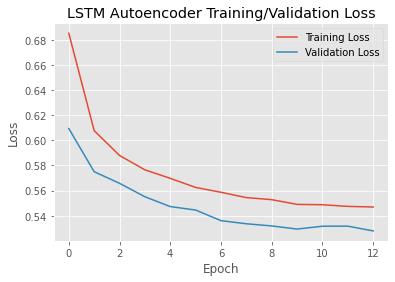

In [0]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Autoencoder Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

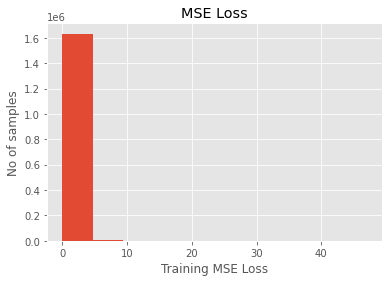

In [0]:
# MSE loss
X_pred = model2.predict(X)
train_mse_loss = np.mean(np.power(X_pred - y,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=10)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
A, l = generate_all_testing(tsf,20)

Number of 1s: 86
This number should be very close to the number of 1s in tsf_labeled

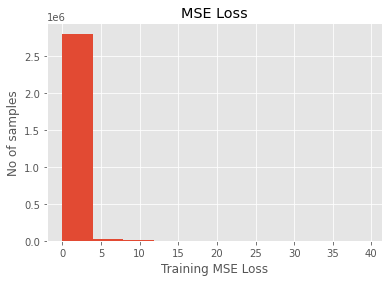

In [0]:
# MSE loss
A_pred = model2.predict(A)
train_mse_loss = np.mean(np.power(A_pred - A,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=10)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

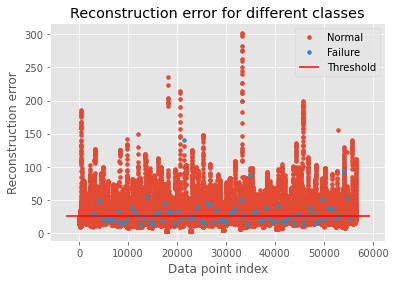

In [0]:
threshold_fixed = 25
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

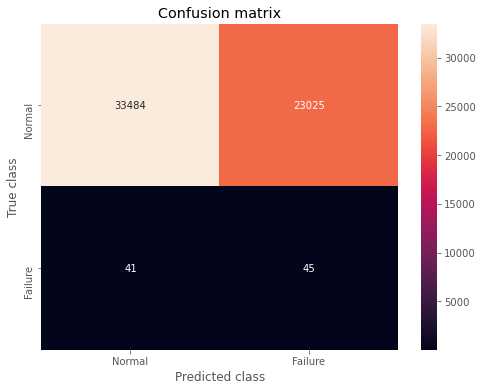

In [0]:
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
print('\nClassification Report:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

Classification Report:
 precision recall f1-score support

 0 1.00 0.59 0.74 56509
 1 0.00 0.52 0.00 86

 accuracy 0.59 56595
 macro avg 0.50 0.56 0.37 56595
weighted avg 1.00 0.59 0.74 56595


F1 Score:
[0.74380789 0.00388668]